In [1]:
import numpy as np
from PIL import Image, ImageDraw
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt

# CNN training

import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2  # Using Inception V4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Labelling the Dataset

In [2]:
def load_images_and_labels(base_path, label_mapping, img_size=(200, 200)):
    images = []
    labels = []
    
    # Iterate through all files in the specified directory
    for filename in os.listdir(base_path):
        if filename.endswith('.png'):  # Check for PNG files
            img_path = os.path.join(base_path, filename)
            img = load_img(img_path, target_size=img_size)

            img_array = img_to_array(img)
            img_array = np.asarray(img_array).astype(np.float32)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            
            # Derive the label from the filename (e.g., 'H', 'X')
            macro_object = filename.split('_')[0]  # Extract the macro-object type
            label = label_mapping.get(macro_object)  # Use .get() to avoid KeyError
            
            if label is None:
                raise ValueError(f"Label for macro_object '{macro_object}' not found in label_mapping.")
            
            images.append(img_array)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [3]:
label_mapping = {'I': 0, 'L': 1, 'T': 2, 'X': 3, 'H': 4, 'O': 5}

# Load the training dataset
X_train, y_train = load_images_and_labels('/proximity_data/train_dataset', label_mapping)
# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=len(label_mapping))

# Load the validation dataset
X_valid, y_valid = load_images_and_labels('/proximity_data/valid_dataset', label_mapping)
# One-hot encode the labels
y_valid_one_hot = to_categorical(y_valid, num_classes=len(label_mapping))

# Load the test dataset
X_test, y_test = load_images_and_labels('/proximity_data/test_dataset', label_mapping)
# One-hot encode the labels
y_test_one_hot = to_categorical(y_test, num_classes=len(label_mapping))

In [4]:
print("Train_dataset shape:" , X_train.shape)
print("Valid_dataset shape:" , X_valid.shape)
print("Test_dataset shape:" , X_test.shape)

Train_dataset shape: (1000, 200, 200, 3)
Valid_dataset shape: (1000, 200, 200, 3)
Test_dataset shape: (1000, 200, 200, 3)


### Training InceptionV4

In [6]:
def build_inceptionV4(input_shape):
    input_tensor = Input(shape=input_shape)

    base_model = InceptionResNetV2(input_tensor=input_tensor, weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=predictions)
    
    return base_model, model

In [15]:
nb_epoch2 = 10
train_sample_len = len(X_train)

base_model, model = build_inceptionV4(input_shape=(200, 200, 3))

In [16]:
datagen = ImageDataGenerator(
        preprocessing_function=None,
        rotation_range=5,
        width_shift_range=0.02,
        height_shift_range=0.02,
        horizontal_flip=True,
        vertical_flip=True
    )

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model_str = f"proximity_incep4-{{epoch:02d}}-{{val_accuracy:.3f}}.weights.h5"
filepath2 = f"/models/{model_str}"
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max', save_weights_only=True)

early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=40)

callbacks_list2 = [early_stopper, checkpoint2]

In [18]:
# Train the model
steps_per_epoch = train_sample_len // 100  
model.fit(datagen.flow(X_train, y_train_one_hot, batch_size=40, shuffle=True),
              steps_per_epoch=steps_per_epoch,
              epochs=nb_epoch2,
              validation_data=(X_valid, y_valid_one_hot),
              callbacks=callbacks_list2)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.3070 - loss: 2.6595 - val_accuracy: 0.3410 - val_loss: 1.7989
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 807ms/step - accuracy: 0.6480 - loss: 1.0152 - val_accuracy: 0.3310 - val_loss: 97.7104
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 788ms/step - accuracy: 0.8183 - loss: 0.4421 - val_accuracy: 0.4860 - val_loss: 7.5655
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8205 - loss: 0.5814 - val_accuracy: 0.6480 - val_loss: 0.7912
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9229 - loss: 0.2057 - val_accuracy: 0.8410 - val_loss: 0.3055
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 581ms/step - accuracy: 0.9610 - loss: 0.1402 - val_accuracy: 0.7870 - val_loss: 0.4460
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 833ms/step - accuracy: 0.8655 - loss: 0.5964 - val_accuracy: 0.6500 - val_loss: 5.7111
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 838ms/step - accuracy: 0.9907 - loss: 0.0493 - val_accuracy: 0.793

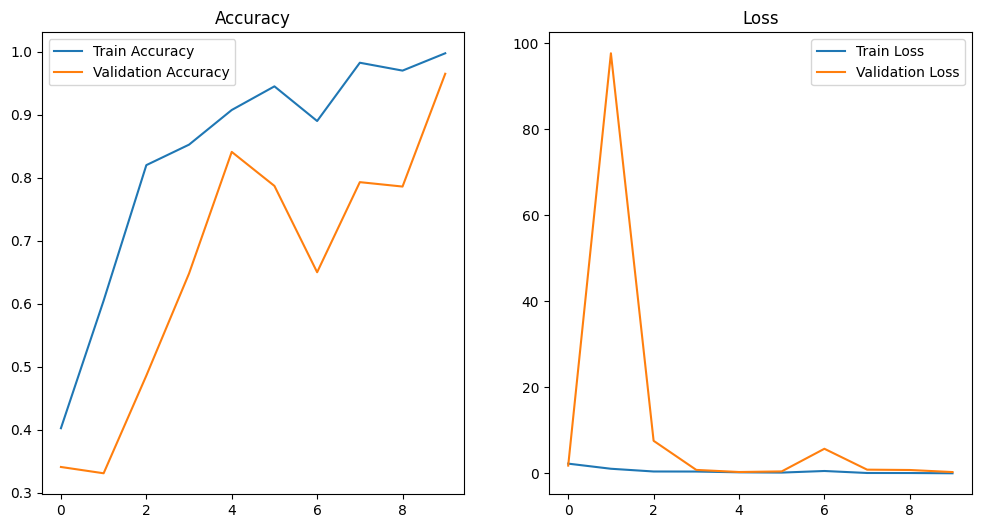

In [19]:
# Plot training progress
history = model.history.history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [20]:
training_model_weights = model.get_weights()
print("Model weights saved to a variable.")

Model weights saved to a variable.


We can see that model is able to learn the Gestalt Principle **Proximity** quite well, as by the 10th epoch, the model reports a training accuracy of **99.32%** and a validation accuracy of **96.5%**

### Testing InceptionV4

In [21]:
base_model, model_test = build_inceptionV4(input_shape=(200, 200, 3))

In [22]:
print('loading weights: ')
model_test.set_weights(training_model_weights)

loading weights: 


In [25]:
preds = model_test.predict(X_test, verbose=0)

In [29]:
# Convert one-hot encoded labels to class indices
y_true_indices = np.argmax(y_test_one_hot, axis=1)
y_pred_indices = np.argmax(preds, axis=1)

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [34]:
# Calculate accuracy
accuracy = accuracy_score(y_true_indices, y_pred_indices)

# Calculate precision and recall (average='macro' for multi-class)
precision = precision_score(y_true_indices, y_pred_indices, average='macro')
recall = recall_score(y_true_indices, y_pred_indices, average='macro')

# Output the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9740
Precision: 0.9764
Recall: 0.9738


In [36]:
ilm = {0 : 'I', 1 : 'L',  2 : 'T',  3 : 'X',  4 : 'H', 5 : 'O'}

In [38]:
# Calculate precision and recall for each class
precision_per_class = precision_score(y_true_indices, y_pred_indices, average=None)
recall_per_class = recall_score(y_true_indices, y_pred_indices, average=None)

# Output the metrics for each class
for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
    print(f"Class {ilm[i]}: Precision = {precision:.4f}, Recall = {recall:.4f}")

Class I: Precision = 0.9750, Recall = 0.9571
Class L: Precision = 0.9699, Recall = 0.9627
Class T: Precision = 1.0000, Recall = 0.9290
Class X: Precision = 1.0000, Recall = 0.9943
Class H: Precision = 1.0000, Recall = 1.0000
Class O: Precision = 0.9135, Recall = 1.0000


#### Final Results

Our InceptionV4 model reports a **training accuracy of 97.4%**, which suggests that the model has learned the concept of proximity pretty well. The specific results for each class are as follows:

| Class | Precision | Recall |
|----------|----------|----------|
| I | 0.97 | 0.96 |
| L | 0.97 | 0.96 |
| T | 1.00 | 0.93 |
| X | 1.00 | 0.99 |
| H | 1.00 | 1.00 |
| O | 0.91 | 1.00 |